# Precipitation tuning pt. 2: profiling thresholds

In this section, we will perform a full analysis on the precipitation adjustment to determine what thresholds we ought to use to adjust the data.

To do this, we will work with summary data from profiling the adjustment. The profiling was performed in a separate step, as it is too intensive to include in a notebook. To run this profiling, run the following command from within this `eda_book` directory:

```sh
python run_pr_profiling.py  --sim_dir <path to regridded data dir> --ref_dir <path to regridded ERA5 dir> --working_dir <path to directory for writing outputs> --partition <slurm partition>
```

This will run the adjustment for all combinations of the following jitter-under and freqeuncy adaptation thresholds:

```
# jitter-under thresholds
['0.01 mm d-1', '0.1 mm d-1', '0.2 mm d-1', '0.3 mm d-1', '0.4 mm d-1']

# frequency adaptation thresholds
['0.05 mm d-1',
 '0.5 mm d-1',
 '1 mm d-1',
 '1.5 mm d-1',
 '2 mm d-1',
 '2.5 mm d-1']
```

These values were chosen based on the epxloratory analysis demonstrated so far in this book, in addition to some that may not be found here. 

The following criteria will be computed on the resulting adjusted data for each combination:

* RMSE of differences of DOY statistics between reference and adjusted:
    * minimum
    * mean
    * maximum
* RMSE of differences of mean indicators:
    * dry spell total length
    * wet spell total length
    * maximum consecutive dry days
    * maximum consecutive wet days



Load the profile summary data:

In [38]:
import pickle
from pathlib import Path

results = {}
results_dir = Path("/beegfs/CMIP6/kmredilla/bias_adjust/profiling/profiling_data")
for file in results_dir.glob("*.pkl"):
    model = file.name.split("_")[0]
    if model not in results:
        results[model] = []
    with open(file, "rb") as f:
        results[model].append(pickle.load(f))

Load and summarize the reference data:

In [15]:
import xarray as xr
from dask.distributed import Client
import dask
from dask_jobqueue import SLURMCluster
from baeda import *

# we have to make some big chunks and this will silence a warning about that
dask.config.set(**{"array.slicing.split_large_chunks": False})

# for interactive nb testing
cluster = SLURMCluster(
    cores=24,
    memory="128GB",
    # queue="debug",
    queue="t2small",
    # walltime="01:00:00",
    walltime="12:00:00",
    log_directory=".",
    account="cmip6",
    interface="ib0",
)
client = Client(cluster)
cluster.scale(1)


ref_var_id = "tp"
ref_start_year = 1993
ref_end_year = 2022
ref_fps = get_era5_fps(era5_dir, ref_var_id, ref_start_year, ref_end_year)
ref_ds = (
    xr.open_mfdataset(ref_fps)
    .convert_calendar("noleap")
    .sel(expver=1)
    .drop_vars("expver")
)

ref = get_rechunked_da(ref_ds, ref_var_id)
ref.attrs["units"] = "m d-1"

# summarize ref results
ref_results = summarize(ref)

cluster.close()
client.close()

/home/kmredilla/miniconda3/envs/new_cmip6_utils/lib/python3.12/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 33029 instead
  warnings.warn(


In [33]:
import pandas as pd
import seaborn as sns
import numpy as np


# maximum differences in max daily precip across whole dataset (grid + doy axis) between adjusted and reference
def diff_doy_with_ref(ref_results, sim_results, col_name, stat, func):
    """Perform a differencing operation on the adjusted simulated summary results against the reference"""
    df = pd.DataFrame(
        [
            {
                col_name: func(
                    (result["results"]["doy"][stat] - ref_results["doy"][stat])
                ).values.item(),
                "ju_thresh": result["ju_thresh"],
                "adapt_freq_thresh": result["adapt_freq_thresh"],
            }
            for result in sim_results
        ]
    )
    df = df.pivot(index="ju_thresh", columns="adapt_freq_thresh", values=col_name)

    return df

In [40]:
test = diff_doy_with_ref(ref_results, results["MIROC6"], "max_max_diffs", "max", np.max)

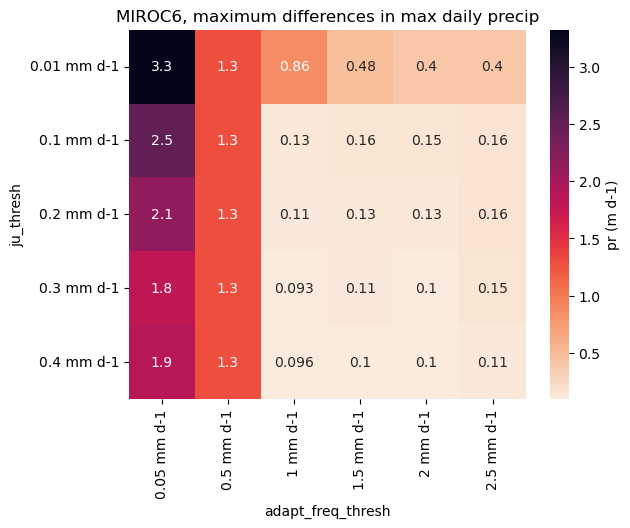

In [50]:
sns.heatmap(
    test, annot=True, cbar_kws={"label": "pr (m d-1)"}, cmap="rocket_r"
).set_title("MIROC6, maximum differences in max daily precip")
plt.show()